#TensorFlow Core Learning Algorithms
In this notebook we will walk through 4 fundemental machine learning algorithms. We will apply each of these algorithms to unique problems and datasets before highlighting the use cases of each.

The algorithms we will focus on include:
- Linear Regression
- Classification
- Clustering
- Hidden Markov Models

It is worth noting that there are many tools within TensorFlow that could be used to solve the problems we will see below. I have chosen the tools that I belive give the most variety and are easiest to use.

##Linear Regression
Linear regression is one of the most basic forms of machine learning and is used to predict numeric values. 

In this tutorial we will use a linear model to predict the survival rate of passangers from the titanic dataset.

*This section is based on the following documentation: https://www.tensorflow.org/tutorials/estimator/linear*


###How it Works
Before we dive in, I will provide a very surface level explination of the linear regression algorithm.

Linear regression follows a very simple concept. If data points are related linearly, we can generate a line of best fit for these points and use it to predict future values.

Let's take an example of a data set with one feature and one label.



(0.0, 6.0, 0.0, 20.0)

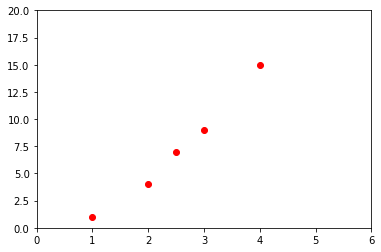

In [10]:
import matplotlib.pyplot as plt
import numpy as np

x = [1, 2, 2.5, 3, 4]
y = [1, 4, 7, 9, 15]
plt.plot(x, y, 'ro')
plt.axis([0, 6, 0, 20])

We can see that this data has a linear coorespondence. When the x value increases, so does the y. Because of this relation we can create a line of best fit for this dataset. In this example our line will only use one input variable, as we are working with two dimensions. In larger datasets with more features our line will have more features and inputs.

"Line of best fit refers to a line through a scatter plot of data points that best expresses the relationship between those points." (https://www.investopedia.com/terms/l/line-of-best-fit.asp)

Here's a refresher on the equation of a line in 2D.

$ y = mx + b $

Here's an example of a line of best fit for this graph.



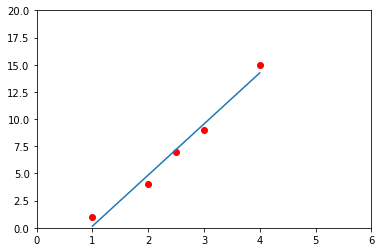

In [11]:
plt.plot(x, y, 'ro')
plt.axis([0, 6, 0, 20])
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.show()

Once we've generated this line for our dataset, we can use its equation to predict future values. We just pass the features of the data point we would like to predict into the equation of the line and use the output as our prediction.

### Setup and Imports
Before we get started we must install *sklearn* and import the following modules.

In [12]:
#!pip install -q sklearn

In [13]:
#%tensorflow_version 2.x  # this line is not required unless you are in a notebook

In [14]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

### Data
So, if you haven't realized by now a major part of machine learning is data! In fact, it's so important that most of what we do in this tutorial will focus on exploring, cleaning and selecting appropriate data.

The dataset we will be focusing on here is the titanic dataset. It has tons of information about each passanger on the ship. Our first step is always to understand the data and explore it. So, let's do that!

**Below we will load a dataset and learn how we can explore it using some built-in tools. **



In [15]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

The ```pd.read_csv()``` method will return to us a new pandas *dataframe*. You can think of a dataframe like a table. In fact, we can actually have a look at the table representation.

We've decided to pop the "survived" column from our dataset and store it in a new variable. This column simply tells us if the person survived our not.

To look at the data we'll use the ```.head()``` method from pandas. This will show us the first 5 items in our dataframe.

In [16]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


And if we want a more statistical analysis of our data we can use the ```.describe()``` method.

In [17]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


And since we talked so much about shapes in the previous tutorial let's have a look at that too!

In [18]:
dftrain.shape

(627, 9)

So have have 627 entries and 9 features, nice!

Now let's have a look at our survival information.

In [19]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

Notice that each entry is either a 0 or 1. Can you guess which stands for survival? 

**And now because visuals are always valuable let's generate a few graphs of the data.**

<AxesSubplot:>

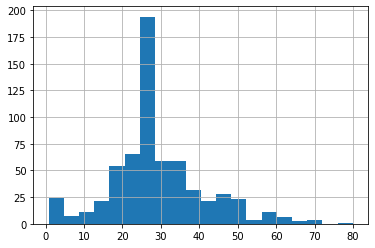

In [20]:
dftrain.age.hist(bins=20)

<AxesSubplot:>

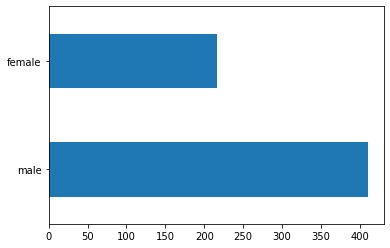

In [21]:
dftrain.sex.value_counts().plot(kind='barh')

<AxesSubplot:>

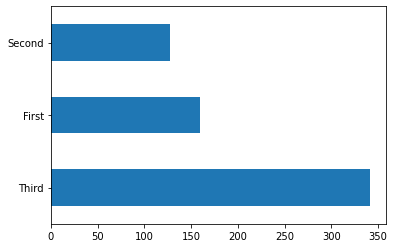

In [22]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

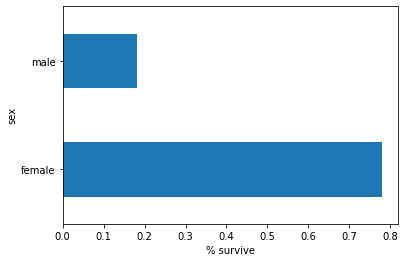

In [23]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

After analyzing this information, we should notice the following:
- Most passengers are in their 20's or 30's 
- Most passengers are male
- Most passengers are in "Third" class
- Females have a much higher chance of survival



### Training vs Testing Data
You may have noticed that we loaded **two different datasets** above. This is because when we train models, we need two sets of data: **training and testing**. 

The **training** data is what we feed to the model so that it can develop and learn. It is usually a much larger size than the testing data.

The **testing** data is what we use to evaulate the model and see how well it is performing. We must use a seperate set of data that the model has not been trained on to evaluate it. Can you think of why this is?

Well, the point of our model is to be able to make predictions on NEW data, data that we have never seen before. If we simply test the model on the data that it has already seen we cannot measure its accuracy accuratly. We can't be sure that the model hasn't simply memorized our training data. This is why we need our testing and training data to be seperate.



###Feature Columns
In our dataset we have two different kinds of information: **Categorical and Numeric**

Our **categorical data** is anything that is not numeric! For example, the sex column does not use numbers, it uses the words "male" and "female".

Before we continue and create/train a model we must convet our categorical data into numeric data. We can do this by encoding each category with an integer (ex. male = 1, female = 2). 

Fortunately for us TensorFlow has some tools to help!

In [24]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

Let's break this code down a little bit...

Essentially what we are doing here is creating a list of features that are used in our dataset. 

The cryptic lines of code inside the ```append()``` create an object that our model can use to map string values like "male" and "female" to integers. This allows us to avoid manually having to encode our dataframes.

*And here is some relevant documentation*

https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list?version=stable



###The Training Process
So, we are almost done preparing our dataset and I feel as though it's a good time to explain how our model is trained. Specifically, how input data is fed to our model. 

For this specific model data is going to be streamed into it in small batches of 32. This means we will not feed the entire dataset to our model at once, but simply small batches of entries. We will feed these batches to our model multiple times according to the number of **epochs**. 

An **epoch** is simply one stream of our entire dataset. The number of epochs we define is the amount of times our model will see the entire dataset. We use multiple epochs in hope that after seeing the same data multiple times the model will better determine how to estimate it.

Ex. if we have 10 ephocs, our model will see the same dataset 10 times. 

Since we need to feed our data in batches and multiple times, we need to create something called an **input function**. The input function simply defines how our dataset will be converted into batches at each epoch.





###Input Function
The TensorFlow model we are going to use requires that the data we pass it comes in as a ```tf.data.Dataset``` object. This means we must create a *input function* that can convert our current pandas dataframe into that object. 

Below you'll see a seemingly complicated input function, this is straight from the TensorFlow documentation (https://www.tensorflow.org/tutorials/estimator/linear). I've commented as much as I can to make it understandble, but you may want to refer to the documentation for a detailed explination of each method.

In [25]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)


###Creating the Model
In this tutorial we are going to use a linear estimator to utilize the linear regression algorithm. 

Creating one is pretty easy! Have a look below.



In [26]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\root\\AppData\\Local\\Temp\\tmpk1nlrwr5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


###Training the Model
Training the model is as easy as passing the input functions that we created earlier.

In [27]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears consoke output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

0.75757575


And we now we have a model with a 74% accuracy (this will change each time)! Not crazy impressive but decent for our first try.

Now let's see how we can actually use this model to make predicitons.

We can use the ```.predict()``` method to get survival probabilities from the model. This method will return a list of dicts that store a predicition for each of the entries in our testing data set. Below we've used some pandas magic to plot a nice graph of the predictions.

As you can see the survival rate is not very high :/

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\root\AppData\Local\Temp\tmpk1nlrwr5\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<AxesSubplot:title={'center':'predicted probabilities'}, ylabel='Frequency'>

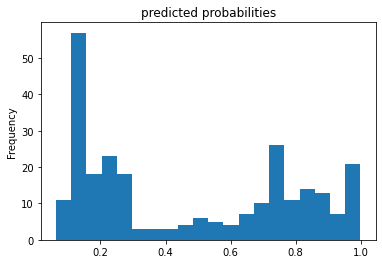

In [28]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

That's it for linear regression! Now onto classification.

##Classification
Now that we've covered linear regression it is time to talk about classification. Where regression was used to predict a numeric value, classification is used to seperate data points into classes of different labels. In this example we will use a TensorFlow estimator to classify flowers.

Since we've touched on how estimators work earlier, I'll go a bit quicker through this example. 

This section is based on the following guide from the TensorFlow website.
https://www.tensorflow.org/tutorials/estimator/premade




###Imports and Setup

In [29]:
#%tensorflow_version 2.x  # this line is not required unless you are in a notebook

UsageError: Line magic function `%tensorflow_version` not found.


In [30]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import pandas as pd

###Dataset
This specific dataset seperates flowers into 3 different classes of species.
- Setosa
- Versicolor
- Virginica

The information about each flower is the following.
- sepal length
- sepal width
- petal length
- petal width

In [31]:
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']
# Lets define some constants to help us later on

In [32]:
train_path = tf.keras.utils.get_file("iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file("iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)
# Here we use keras (a module inside of TensorFlow) to grab our datasets and read them into a pandas dataframe

Let's have a look at our data.

In [33]:
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


Now we can pop the species column off and use that as our label.

In [34]:
train_y = train.pop('Species')
test_y = test.pop('Species')
train.head() # the species column is now gone

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1
4,5.7,3.8,1.7,0.3


In [35]:
train.shape  # we have 120 entires with 4 features

(120, 4)

###Input Function
Remember that nasty input function we created earlier. Well we need to make another one here! Fortunatly for us this one is a little easier to digest.

In [36]:
def input_fn(features, labels, training=True, batch_size=256):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)


###Feature Columns
And you didn't think we forgot about the feature columns, did you?



In [37]:
# Feature columns describe how to use the input.
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
print(my_feature_columns)

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


###Building the Model
And now we are ready to choose a model. For classification tasks there are variety of different estimators/models that we can pick from. Some options are listed below.
- ```DNNClassifier``` (Deep Neural Network)
- ```LinearClassifier```

We can choose either model but the DNN seems to be the best choice. This is because we may not be able to find a linear coorespondence in our data. 

So let's build a model!

In [38]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 3 classes.
    n_classes=3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\root\\AppData\\Local\\Temp\\tmphxk3rrn8', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


What we've just done is created a deep neural network that has two hidden layers. These layers have 30 and 10 neurons respectively. This is the number of neurons the TensorFlow official tutorial uses so we'll stick with it. However, it is worth mentioning that the number of hidden neurons is an arbitrary number and many experiments and tests are usually done to determine the best choice for these values. Try playing around with the number of hidden neurons and see if your results change.

###Training
Now it's time to train the model!

In [39]:
classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=5000)
# We include a lambda to avoid creating an inner function previously

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\root\AppData\Local\Temp\tmphxk3rrn8\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 1.1527247, step = 0
INFO:tensorflow:global_step/sec: 438.76
INFO:tensorflow:loss = 0.9938086, step = 100 (0.230 sec)
INFO:tensorflow:global_step/sec: 571.665
INFO:tensorflow:loss = 0.9265864, step = 200 (0.175 sec)
INFO:tensorflow:global_step/sec: 485.102
INFO:tensorflow:loss = 0.87370396, step = 300 (0.205 sec)
INFO:tensorflow:global_step/sec: 490.273
INFO:tensorflow:loss = 0.83536303, step = 400 (0.205 sec)
INFO:tensorflow:global_step/sec: 493.219
INFO:tensorflow:loss = 0.8002542, 

The only thing to explain here is the **steps** argument. This simply tells the classifier to run for 5000 steps. Try modifiying this and seeing if your results change. Keep in mind that more is not always better.

###Evaluation
Now let's see how this trained model does!

In [40]:
eval_result = classifier.evaluate(input_fn=lambda: input_fn(test, test_y, training=False))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-11-04T08:24:54
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\root\AppData\Local\Temp\tmphxk3rrn8\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.18923s
INFO:tensorflow:Finished evaluation at 2021-11-04-08:24:55
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.96666664, average_loss = 0.44803387, global_step = 5000, loss = 0.44803387
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: C:\Users\root\AppData\Local\Temp\tmphxk3rrn8\model.ckpt-5000

Test set accuracy: 0.967



Notice this time we didn't specify the number of steps. This is because during evaluation the model will only look at the testing data one time.

### Predictions
Now that we have a trained model it's time to use it to make predictions. I've written a little script below that allows you to type the features of a flower and see a prediction for its class.

In [1]:
def input_fn(features, batch_size=256):
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

features = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
predict = {}

print("Please type numeric values as prompted.")
for feature in features:
  valid = True
  while valid:
    val = input(feature + ": ")
    if not val.isdigit(): valid = False

  predict[feature] = [np.float(val)]

predictions = classifier.predict(input_fn=lambda: input_fn(predict))
for pred_dict in predictions:
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]

    print('Prediction is "{}" ({:.1f}%)'.format(SPECIES[class_id], 100 * probability))

Please type numeric values as prompted.


KeyboardInterrupt: Interrupted by user

In [ ]:
# Here is some example input and expected classes you can try above
expected = ['Setosa', 'Versicolor', 'Virginica']
predict_x = {
    'SepalLength': [5.1, 5.9, 6.9],
    'SepalWidth': [3.3, 3.0, 3.1],
    'PetalLength': [1.7, 4.2, 5.4],
    'PetalWidth': [0.5, 1.5, 2.1],
}

And that's pretty much it for classification! 

##Clustering
Now that we've covered regression and classification it's time to talk about clustering data! 

Clustering is a Machine Learning technique that involves the grouping of data points. In theory, data points that are in the same group should have similar properties and/or features, while data points in different groups should have highly dissimilar properties and/or features. (https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68)

Unfortunalty there are issues with the current version of TensorFlow and the implementation for KMeans. This means we cannot use KMeans without writing the algorithm from scratch. We aren't quite at that level yet, so we'll just explain the basics of clustering for now.

####Basic Algorithm for K-Means.
- Step 1: Randomly pick K points to place K centroids
- Step 2: Assign all the data points to the centroids by distance. The closest centroid to a point is the one it is assigned to.
- Step 3: Average all the points belonging to each centroid to find the middle of those clusters (center of mass). Place the corresponding centroids into that position.
- Step 4: Reassign every point once again to the closest centroid.
- Step 5: Repeat steps 3-4 until no point changes which centroid it belongs to.

*Please refer to the video for an explanation of KMeans clustering.*

##Hidden Markov Models

"The Hidden Markov Model is a finite set of states, each of which is associated with a (generally multidimensional) probability distribution []. Transitions among the states are governed by a set of probabilities called transition probabilities." (http://jedlik.phy.bme.hu/~gerjanos/HMM/node4.html)

A hidden markov model works with probabilities to predict future events or states. In this section we will learn how to create a hidden markov model that can predict the weather.

*This section is based on the following TensorFlow tutorial.* https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/HiddenMarkovModel

###Data
Let's start by discussing the type of data we use when we work with a hidden markov model. 

In the previous sections we worked with large datasets of 100's of different entries. For a markov model we are only interested in probability distributions that have to do with states. 

We can find these probabilities from large datasets or may already have these values. We'll run through an example in a second that should clear some things up, but let's discuss the components of a markov model.

**States:** In each markov model we have a finite set of states. These states could be something like "warm" and "cold" or "high" and "low" or even "red", "green" and "blue". These states are "hidden" within the model, which means we do not direcly observe them.

**Observations:** Each state has a particular outcome or observation associated with it based on a probability distribution. An example of this is the following: *On a hot day Tim has a 80% chance of being happy and a 20% chance of being sad.*

**Transitions:** Each state will have a probability defining the likelyhood of transitioning to a different state. An example is the following: *a cold day has a 30% chance of being followed by a hot day and a 70% chance of being follwed by another cold day.*

To create a hidden markov model we need.
- States
- Observation Distribution
- Transition Distribution

For our purpose we will assume we already have this information available as we attempt to predict the weather on a given day.

###Imports and Setup

In [ ]:
#%tensorflow_version 2.x  # this line is not required unless you are in a notebook

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


Due to a version mismatch with tensorflow v2 and tensorflow_probability we need to install the most recent version of tensorflow_probability (see below).

In [ ]:
#!pip install tensorflow_probability==0.8.0rc0 --user --upgrade

     |████████████████████████████████| 2.5MB 2.7MB/s 
ERROR: gym 0.17.2 has requirement cloudpickle<1.4.0,>=1.2.0, but you'll have cloudpickle 1.1.1 which is incompatible.


In [ ]:
import tensorflow_probability as tfp  # We are using a different module from tensorflow this time
import tensorflow as tf

###Weather Model
Taken direclty from the TensorFlow documentation (https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/HiddenMarkovModel). 

We will model a simple weather system and try to predict the temperature on each day given the following information.
1. Cold days are encoded by a 0 and hot days are encoded by a 1.
2. The first day in our sequence has an 80% chance of being cold.
3. A cold day has a 30% chance of being followed by a hot day.
4. A hot day has a 20% chance of being followed by a cold day.
5. On each day the temperature is
 normally distributed with mean and standard deviation 0 and 5 on
 a cold day and mean and standard deviation 15 and 10 on a hot day.

If you're unfamiliar with **standard deviation** it can be put simply as the range of expected values. 

In this example, on a hot day the average temperature is 15 and ranges from 5 to 25.

To model this in TensorFlow we will do the following.


In [ ]:
tfd = tfp.distributions  # making a shortcut for later on
initial_distribution = tfd.Categorical(probs=[0.2, 0.8])  # Refer to point 2 above
transition_distribution = tfd.Categorical(probs=[[0.5, 0.5],[0.2, 0.8]])  # refer to points 3 and 4 above
observation_distribution = tfd.Normal(loc=[0., 15.], scale=[5., 10.])  # refer to point 5 above

# the loc argument represents the mean and the scale is the standard devitation

We've now created distribution variables to model our system and it's time to create the hidden markov model.

In [ ]:
model = tfd.HiddenMarkovModel(
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    observation_distribution=observation_distribution,
    num_steps=7)

The number of steps represents the number of days that we would like to predict information for. In this case we've chosen 7, an entire week.

To get the **expected temperatures** on each day we can do the following.

In [ ]:
mean = model.mean()

# due to the way TensorFlow works on a lower level we need to evaluate part of the graph
# from within a session to see the value of this tensor

# in the new version of tensorflow we need to use tf.compat.v1.Session() rather than just tf.Session()
with tf.compat.v1.Session() as sess:  
  print(mean.numpy())

[12.       11.1      10.83     10.748999 10.724699 10.71741  10.715222]


##Conclusion
So that's it for the core learning algorithms in TensorFlow. Hopefully you've learned about a few interesting tools that are easy to use! To practice I'd encourage you to try out some of these algorithms on different datasets.

##Sources

1. Chen, James. “Line Of Best Fit.” Investopedia, Investopedia, 29 Jan. 2020, www.investopedia.com/terms/l/line-of-best-fit.asp.
2. “Tf.feature_column.categorical_column_with_vocabulary_list.” TensorFlow, www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list?version=stable.
3. “Build a Linear Model with Estimators &nbsp;: &nbsp; TensorFlow Core.” TensorFlow, www.tensorflow.org/tutorials/estimator/linear.
4. Staff, EasyBib. “The Free Automatic Bibliography Composer.” EasyBib, Chegg, 1 Jan. 2020, www.easybib.com/project/style/mla8?id=1582473656_5e52a1b8c84d52.80301186.
5. Seif, George. “The 5 Clustering Algorithms Data Scientists Need to Know.” Medium, Towards Data Science, 14 Sept. 2019, https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68.
6. Definition of Hidden Markov Model, http://jedlik.phy.bme.hu/~gerjanos/HMM/node4.html.
7. “Tfp.distributions.HiddenMarkovModel &nbsp;: &nbsp; TensorFlow Probability.” TensorFlow, www.tensorflow.org/probability/api_docs/python/tfp/distributions/HiddenMarkovModel.